In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [2]:
df = pd.read_csv('data/drexler_complete_lyrics.csv', sep=';')
df.sample(10)

,id,lyrics,title,url,album,year
23,1073134,Cuatro estrellas blancas sobre fondo negro Es ...,Luna negra,https://genius.com/Jorge-drexler-luna-negra-ly...,Vaivén,1996
52,1673647,En cambio constante Todo se mueve y deja de se...,Durante,https://genius.com/Jorge-drexler-durante-lyrics,Sea,2001
38,1758200,"Tu piel, tu piel, tu piel, tu piel, tu piel Bu...",Tu piel,https://genius.com/Jorge-drexler-tu-piel-lyrics,Llueve,1997
86,1395005,"Gracias, gracias, gracias Quiero agradecer a q...",Gracias,https://genius.com/Jorge-drexler-gracias-lyrics,Cara B,2008
57,1176108,"Busca mis ojos Toma mi mano, acércate Este es ...",Raquel,https://genius.com/Jorge-drexler-raquel-lyrics,Sea,2001
35,1250056,Con mi amor yo quiero bailar Murga Reggae Con ...,Murga reggae,https://genius.com/Jorge-drexler-murga-reggae-...,Llueve,1997
104,1949045,Yo miraba la luna de Rasquí Tumbado en la aren...,La Luna de Rasquí,https://genius.com/Jorge-drexler-la-luna-de-ra...,Bailar en la cueva,2014
40,1360422,Era el tiempo del cambio El tiempo de la estam...,Aquellos tiempos,https://genius.com/Jorge-drexler-aquellos-tiem...,Frontera,1999
42,992900,Corazón de cristal Que no he visto dos veces B...,Corazón de cristal,https://genius.com/Jorge-drexler-corazon-de-cr...,Frontera,1999
103,1990739,Voy con una trayectoria lenta Por mucho que me...,Esfera,https://genius.com/Jorge-drexler-esfera-lyrics,Bailar en la cueva,2014


### Let's start with wordcount
##### Following: http://sigdelta.com/blog/text-analysis-in-pandas/

In [3]:
df['words'] = df.lyrics.str.strip().str.split('[\W_]+')

In [4]:
rows = list()
for row in df[['words']].iterrows():
    r = row[1]
    for word in r.words:
        rows.append((word))

words = pd.DataFrame(rows, columns=['word'])
words.head()

,word
0,El
1,perfume
2,de
3,la
4,sal


In [5]:
#Remove empty rows and cases
words = words[words.word.str.len() > 0]
words['word'] = words.word.str.lower()
words.head()

,word
0,el
1,perfume
2,de
3,la
4,sal


In [6]:
#Word count per song
counts = words\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})
counts

,n_w
de,807
que,661
la,621
el,572
y,521
en,490
no,347
a,312
un,260
tu,251


## So, from this we get to know two important facts
 - Most used words in Jorge Drexler's songs are 'de', 'que', 'la', 'el' and 'y'
 - We need to exclude stopwords.

In [7]:
from nltk.corpus import stopwords
stopwords = stopwords.words('spanish')

In [8]:
for a_stopword in stopwords:
    if a_stopword in counts.index:
        counts = counts.drop(a_stopword)

In [9]:
counts.head(20)

,n_w
na,120
mar,88
tiempo,82
luna,61
noche,61
corazón,56
bailar,51
si,50
dos,49
amor,47


### WTF is that 'na' topping the list?

In [10]:
songs = list()
for row in df[['title','words']].iterrows():
    r = row[1]
    if 'na' in r.words:
        songs.append(r.title)

songs

['Estalactitas']

### Now it's pretty obvious, just listen to the song.

In [11]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/YFBe7hLUPKo?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


In [12]:
counts = counts.drop('na')
counts.head(20)

,n_w
mar,88
tiempo,82
luna,61
noche,61
corazón,56
bailar,51
si,50
dos,49
amor,47
va,46


In [15]:
words_by_album = {}
top_five_words = counts.head(5).index
for row in df[['album','words','year']].iterrows():
    r = row[1]
    if r.album not in words_by_album:
        words_by_album[r.album] = {
            top_five_words[0]: 0,
            top_five_words[1]: 0,
            top_five_words[2]: 0,
            top_five_words[3]: 0,
            top_five_words[4]: 0
        }
    for a_word in r.words:
        if a_word == top_five_words[0]:
            words_by_album[r.album][top_five_words[0]] += 1
        if a_word == top_five_words[1]:
            words_by_album[r.album][top_five_words[1]] += 1
        if a_word == top_five_words[2]:
            words_by_album[r.album][top_five_words[2]] += 1
        if a_word == top_five_words[3]:
            words_by_album[r.album][top_five_words[3]] += 1
        if a_word == top_five_words[4]:
            words_by_album[r.album][top_five_words[4]] += 1

             
            
words_by_album

{'11 Segundos de Oscuridad': {'corazón': 4,
  'luna': 1,
  'mar': 4,
  'noche': 5,
  'tiempo': 4},
 'Amar la trama': {'corazón': 4, 'luna': 3, 'mar': 9, 'noche': 4, 'tiempo': 2},
 'Bailar en la cueva': {'corazón': 3,
  'luna': 29,
  'mar': 1,
  'noche': 14,
  'tiempo': 6},
 'Cara B': {'corazón': 0, 'luna': 0, 'mar': 1, 'noche': 0, 'tiempo': 2},
 'Eco': {'corazón': 2, 'luna': 0, 'mar': 2, 'noche': 0, 'tiempo': 3},
 'Frontera': {'corazón': 4, 'luna': 5, 'mar': 10, 'noche': 0, 'tiempo': 26},
 'La Luz Que Sabe Robar': {'corazón': 1,
  'luna': 1,
  'mar': 3,
  'noche': 0,
  'tiempo': 0},
 'Llueve': {'corazón': 5, 'luna': 4, 'mar': 26, 'noche': 4, 'tiempo': 0},
 'Others': {'corazón': 0, 'luna': 0, 'mar': 0, 'noche': 0, 'tiempo': 2},
 'Radar': {'corazón': 3, 'luna': 4, 'mar': 22, 'noche': 11, 'tiempo': 2},
 'Salvavidas de hielo': {'corazón': 0,
  'luna': 0,
  'mar': 0,
  'noche': 18,
  'tiempo': 23},
 'Sea': {'corazón': 6, 'luna': 1, 'mar': 8, 'noche': 0, 'tiempo': 2},
 'Vaivén': {'corazón': 

In [14]:
top_five_words

Index(['mar', 'tiempo', 'luna', 'noche', 'corazón'], dtype='object')

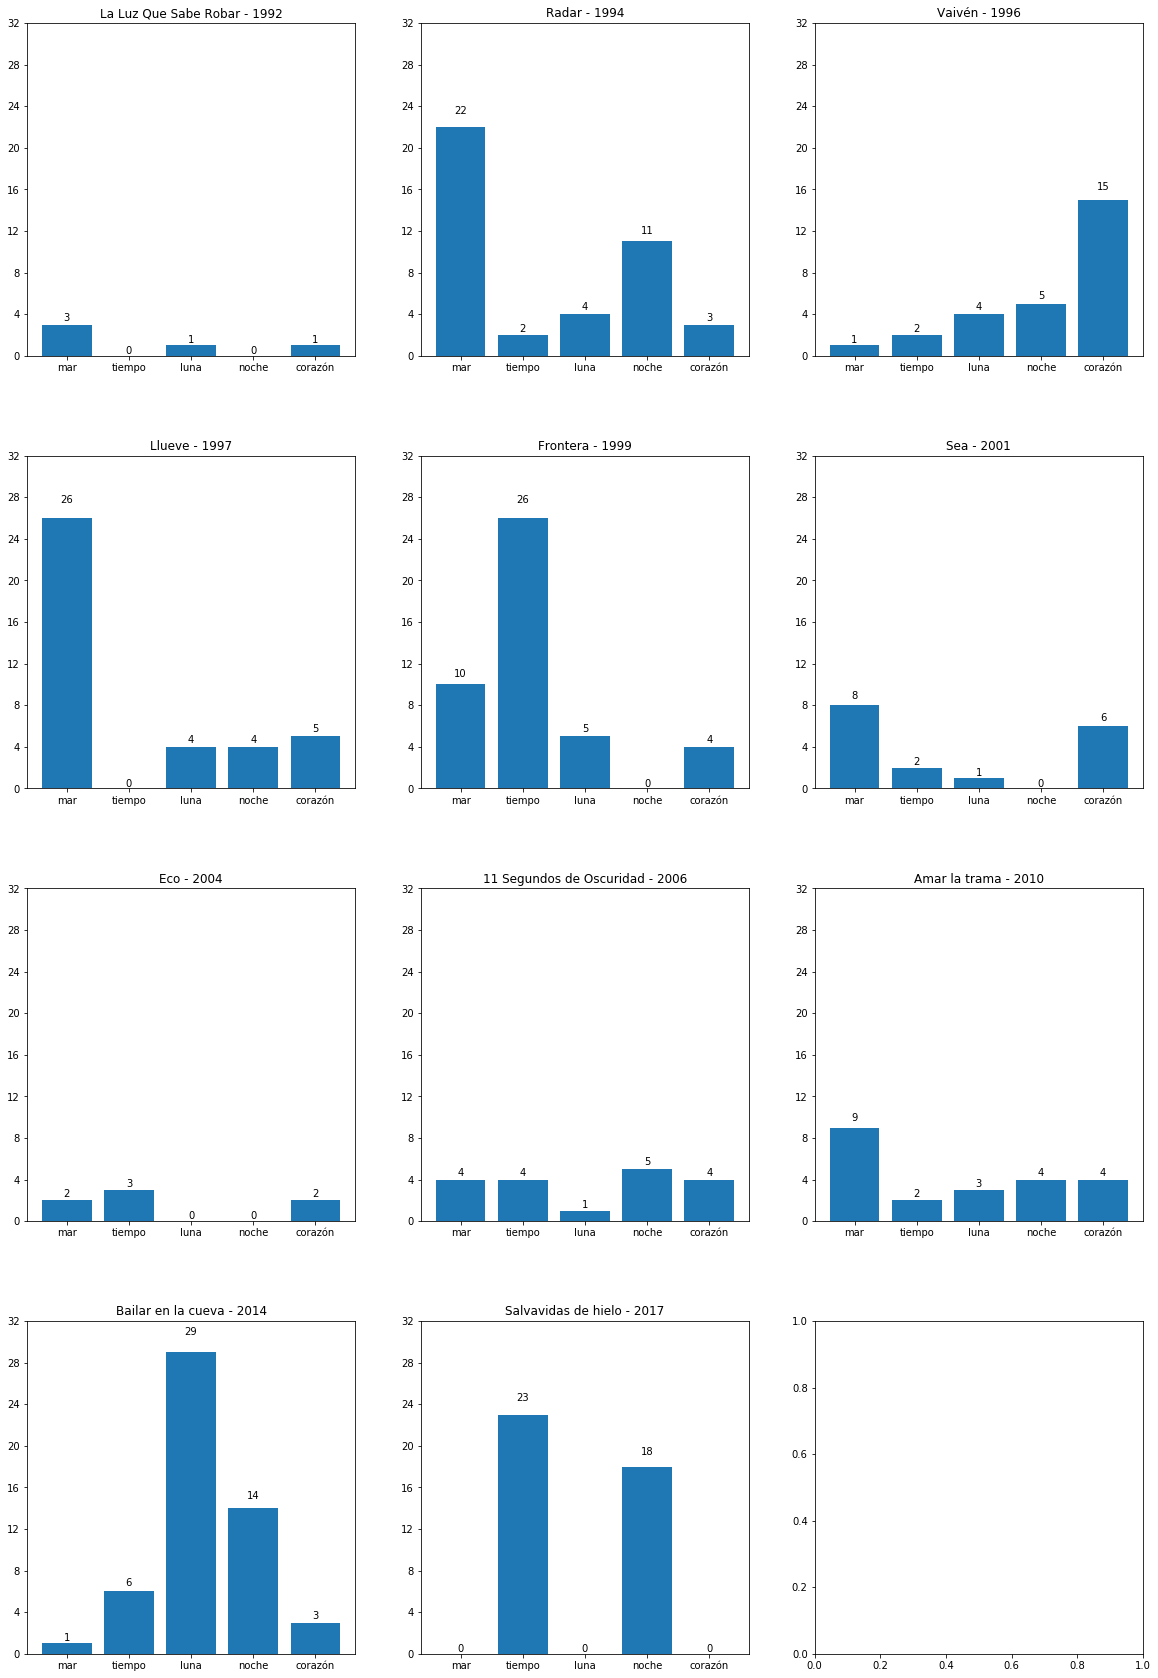

In [50]:
ROWS = 4
COLS = 3
max_appearance = 0
for album in words_by_album:
    for word in words_by_album[album]:
        a_number = words_by_album[album][word]
        if a_number > max_appearance:
            max_appearance = a_number

fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))
albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '11 Segundos de Oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo'
]
years_for_albums = [
    1992, 1994, 1996, 1997, 1999, 
    2001, 2004, 2006, 2010, 2014, 
    2017
]

def autolabel(rects, x, y):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axes[x,y].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')


for row in range(ROWS):
    for col in range(COLS):
        if not albums_ordered_by_year:
            break
        an_album_title = albums_ordered_by_year.pop(0)
        an_album_year = years_for_albums.pop(0)
        an_album = words_by_album[an_album_title]
        rects = axes[row, col].bar(range(len(an_album)), list(an_album.values()), align='center')
        axes[row, col].set_xticks(range(len(an_album)))
        axes[row, col].set_xticklabels(list(an_album.keys()))
        axes[row, col].yaxis.set_major_locator(MaxNLocator(integer=True))
        axes[row, col].set_ylim([0,max_appearance + 3])
        axes[row, col].set_title("%s - %d" % (an_album_title, an_album_year))
        autolabel(rects, row, col)

for ax_x in axes:
    for ax_y in ax_x:
        ax_y.xaxis.label.set_visible(False)
plt.subplots_adjust(hspace = 0.3)
plt.show()

In [47]:
list(an_album.keys())

['mar', 'tiempo', 'luna', 'noche', 'corazón']